<a href="https://colab.research.google.com/github/Iyad-Alhasan/FHE_Expirements/blob/main/encrypt_rotate_example_CKKS_Iyad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from numpy.polynomial import Polynomial

class CKKSEncoder:
    """Basic CKKS encoder to encode complex vectors into polynomials."""

    def __init__(self, M: int):
        """Initialization of the encoder for M a power of 2.

        xi, which is an M-th root of unity will, be used as a basis for our computations.
        """
        self.xi = np.exp(2 * np.pi * 1j / M)
        self.M = M

    @staticmethod
    def vandermonde(xi: np.complex128, M: int) -> np.array:
        """Computes the Vandermonde matrix from a m-th root of unity."""

        N = M //2
        matrix = []
        # We will generate each row of the matrix
        for i in range(N):
            # For each row we select a different root
            root = xi ** (2 * i + 1)
            row = []

            # Then we store its powers
            for j in range(N):
                row.append(root ** j)
            matrix.append(row)
        return matrix

    def sigma_inverse(self, b: np.array) -> Polynomial:
        """Encodes the vector b in a polynomial using an M-th root of unity."""

        # First we create the Vandermonde matrix
        A = CKKSEncoder.vandermonde(self.xi, M)

        # Then we solve the system
        coeffs = np.linalg.solve(A, b)

        # Finally we output the polynomial
        p = Polynomial(coeffs)
        return p

    def sigma(self, p: Polynomial) -> np.array:
        """Decodes a polynomial by applying it to the M-th roots of unity."""

        outputs = []
        N = self.M //2

        # We simply apply the polynomial on the roots
        for i in range(N):
            root = self.xi ** (2 * i + 1)
            output = p(root)
            outputs.append(output)
        return np.array(outputs)

In [ ]:
!pip3 install fastcore

from fastcore.foundation import patch_to

In [ ]:
@patch_to(CKKSEncoder)
def pi(self, z: np.array) -> np.array:
    """Projects a vector of H into C^{N/2}."""

    N = self.M // 4
    return z[:N]

@patch_to(CKKSEncoder)
def pi_inverse(self, z: np.array) -> np.array:
    """Expands a vector of C^{N/2} by expanding it with its
    complex conjugate."""

    z_conjugate = z[::-1]
    z_conjugate = [np.conjugate(x) for x in z_conjugate]
    return np.concatenate([z, z_conjugate])

M = 8

# We can now initialize our encoder with the added methods
encoder = CKKSEncoder(M)

In [ ]:
@patch_to(CKKSEncoder)
def create_sigma_R_basis(self):
    """Creates the basis (sigma(1), sigma(X), ..., sigma(X** N-1))."""

    self.sigma_R_basis = np.array(self.vandermonde(self.xi, self.M)).T

@patch_to(CKKSEncoder)
def __init__(self, M):
    """Initialize with the basis"""
    self.xi = np.exp(2 * np.pi * 1j / M)
    self.M = M
    self.create_sigma_R_basis()

encoder = CKKSEncoder(M)

In [ ]:
@patch_to(CKKSEncoder)
def compute_basis_coordinates(self, z):
    """Computes the coordinates of a vector with respect to the orthogonal lattice basis."""
    output = np.array([np.real(np.vdot(z, b) / np.vdot(b,b)) for b in self.sigma_R_basis])
    return output

def round_coordinates(coordinates):
    """Gives the integral rest."""
    coordinates = coordinates - np.floor(coordinates)
    return coordinates

def coordinate_wise_random_rounding(coordinates):
    """Rounds coordinates randonmly."""
    r = round_coordinates(coordinates)
    f = np.array([np.random.choice([c, c-1], 1, p=[1-c, c]) for c in r]).reshape(-1)

    rounded_coordinates = coordinates - f
    rounded_coordinates = [int(coeff) for coeff in rounded_coordinates]
    return rounded_coordinates

@patch_to(CKKSEncoder)
def sigma_R_discretization(self, z):
    """Projects a vector on the lattice using coordinate wise random rounding."""
    coordinates = self.compute_basis_coordinates(z)

    rounded_coordinates = coordinate_wise_random_rounding(coordinates)
    y = np.matmul(self.sigma_R_basis.T, rounded_coordinates)
    return y

encoder = CKKSEncoder(M)

In [ ]:
@patch_to(CKKSEncoder)
def __init__(self, M:int, scale:float):
    """Initializes with scale."""
    self.xi = np.exp(2 * np.pi * 1j / M)
    self.M = M
    self.create_sigma_R_basis()
    self.scale = scale

@patch_to(CKKSEncoder)
def encode(self, z: np.array) -> Polynomial:
    """Encodes a vector by expanding it first to H,
    scale it, project it on the lattice of sigma(R), and performs
    sigma inverse.
    """
    pi_z = self.pi_inverse(z)
    scaled_pi_z = self.scale * pi_z
    rounded_scale_pi_zi = self.sigma_R_discretization(scaled_pi_z)
    p = self.sigma_inverse(rounded_scale_pi_zi)

    # We round it afterwards due to numerical imprecision
    coef = np.round(np.real(p.coef)).astype(int)
    p = Polynomial(coef)
    return p

@patch_to(CKKSEncoder)
def decode(self, p: Polynomial) -> np.array:
    """Decodes a polynomial by removing the scale,
    evaluating on the roots, and project it on C^(N/2)"""
    rescaled_p = p / self.scale
    z = self.sigma(rescaled_p)
    pi_z = self.pi(z)
    return pi_z

scale = 64

encoder = CKKSEncoder(M, scale)

We can now see it on action, the full encoder used by CKKS :

In [ ]:
z = np.array([3 +4j, 2 - 1j])
z

array([3.+4.j, 2.-1.j])

In [ ]:
z = np.array([3, 2 ])

In [ ]:
p = encoder.encode(z)
p

Polynomial([160.,  22.,   0., -22.], domain=[-1,  1], window=[-1,  1], symbol='x')

In [ ]:

#Public & Secret Key generation

A = [4,1,11,10] #value based on M=8 (N=4)
s = [6,9,11,11] #value based on M=8 (N=4)
e =[0,-1,1,1] #value based on M=8 (N=4)

n=len(A)
q=8192

print (A,s,e)

xN_1 = [1] + [0] * (n-1) + [1] #value based on M=8 (N=4) so : X^4+1

print (xN_1)
A = np.floor(np.polydiv(A,xN_1)[1])

#constructing b (the public key)
b = np.polymul(-A,s)
b = np.floor(np.polydiv(b,xN_1)[1])
b= np.polyadd(b,e)

b = np.floor(np.polydiv(b,xN_1)[1]) #taking the remainder of division by cyclotomic polynomial x^4+1

print ("Print output\n",b)


[4, 1, 11, 10] [6, 9, 11, 11] [0, -1, 1, 1]
[1, 0, 0, 0, 1]
Print output
 [-214. -199. -188.   10.]


In [ ]:
#Encryption

c0 = np.polyadd(p.coef, b)

c0 = np.polydiv(c0,xN_1)[1] #taking the remainder of division by cyclotomic polynomial x^4+1
c1=A
print(f"ciphertext polynomials = \nc0: {Polynomial(c0)}\nc1: {Polynomial(c1)}")


ciphertext polynomials = 
c0: -54.0 - 177.0·x - 188.0·x² - 12.0·x³
c1: 4.0 + 1.0·x + 11.0·x² + 10.0·x³


In [ ]:
#Decryption

messagepoly= np.polyadd(c0, np.polydiv(np.polymul(c1,s),xN_1)[1])
print (f"Plaintext polynomial:\n{Polynomial(messagepoly)}")
message = encoder.decode(Polynomial(messagepoly))
print (f"message: {message}")


Plaintext polynomial:
160.0 + 21.0·x + 1.0·x² - 21.0·x³
message: [2.96403883+0.015625j 2.03596117-0.015625j]


In [ ]:
#Rotate

number_Rot = 1
Galois_key = (5 ** number_Rot) %M
highest_index = np.size(c0)-1
print(Galois_key)
print(highest_index)

c0_rotated = np.zeros(highest_index*Galois_key+1)
c1_rotated = np.zeros(highest_index*Galois_key+1)
skey_rotated = np.zeros(highest_index*Galois_key+1)
i=0
while i<= highest_index:
  c0_rotated[(i*Galois_key)] = c0[i]
  c1_rotated[(i*Galois_key)] = c1[i]
  skey_rotated[(i*Galois_key)] = s[i]
  i=i+1


c0_r = np.polydiv(c0_rotated,xN_1)[1]
c1_r =  np.polydiv(c1_rotated,xN_1)[1]
sA_r =  np.polydiv(skey_rotated,xN_1)[1]
#print(skey_rotated,sA_r)
print(s, sA_r)
print(c0, c0_r)
print(c1,c1_r)




5
3
[6, 9, 11, 11] [ -6.   9. -11.  11.]
[ -54. -177. -188.  -12.] [  54. -177.  188.  -12.]
[ 4.  1. 11. 10.] [ -4.   1. -11.  10.]


In [ ]:

#Decryption after trying to rotate

messagepoly= np.polyadd(c0_r, np.polydiv(np.polymul(c1_r,sA_r),xN_1)[1])
print (messagepoly)

message = encoder.decode(Polynomial(messagepoly))
print (message)



[-160.   21.   -1.  -21.]
[-2.03596117-0.015625j -2.96403883+0.015625j]


#real part of the result is having sign is inverted meaning that we are using the incorrect roots to evaluate (we are using the mirrored root along imaginary access). I believe this has to do with a misalignment between the encoding method and rotation method (choice of generator). (I believe root 1 is used in place of 3 and 7 in place of 5)
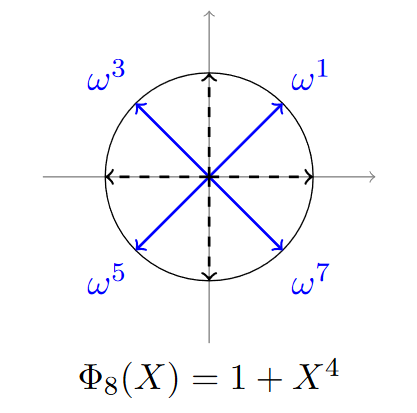